# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [26]:
num_epochs = 100
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [27]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [28]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [29]:
#오래걸려서 1000개만..
train_paths = glob('/Users/eunchankim/Desktop/dataset/cifar/train/*.png')[:1000]
test_paths = glob('/Users/eunchankim/Desktop/dataset/cifar/test/*.png')[:1000]

len(train_paths), len(test_paths)

(1000, 1000)

In [30]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [31]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [32]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [33]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [34]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [37]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

http://localhost:6006

In [38]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

/opt/homebrew/Caskroom/miniforge/base/envs/tf1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
31/31 [==============================] - 1s 25ms/step - loss: 2.3476 - accuracy: 0.1117 - val_loss: 2.2950 - val_accuracy: 0.1048
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 2.3022 - accuracy: 0.1315 - val_loss: 2.3292 - val_accuracy: 0.0958
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 3.5613 - accuracy: 0.1057 - val_loss: 2.5031 - val_accuracy: 0.1502
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 10.1584 - accuracy: 0.1110 - val_loss: 14.4658 - val_accuracy: 0.1099
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 42.1315 - accuracy: 0.1285 - val_loss: 2.8187 - val_accuracy: 0.1804
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 7.5599 - accuracy: 0.1395 - val_loss: 18.3691 - val_accuracy: 0.1210
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 122.5443 - accuracy: 0.1304 - val_loss: 37.6678 - val_accuracy: 0.1845

# History 

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 31}

In [41]:
new_model = history.model

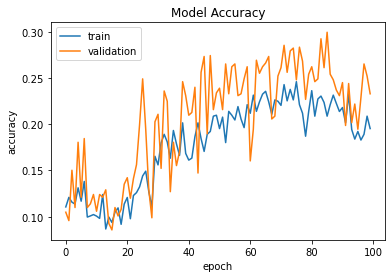

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

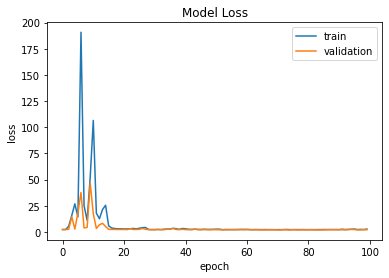

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()